In [2]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
%config InlineBackend.figure_format = 'retina'


# Load Stock dataset
stock = pd.read_csv("../ALBRK.csv", parse_dates=["Date"])
stock = stock.set_index("Date").to_period("D")
stock.drop(["Open", "High", "Low", "Adj Close", "Volume"], axis = 1, inplace=True)
stock.head()

,Close
Date,
2010-01-01,1.196240
2010-01-04,1.196240
2010-01-05,1.244736
2010-01-06,1.282456
2010-01-07,1.309398


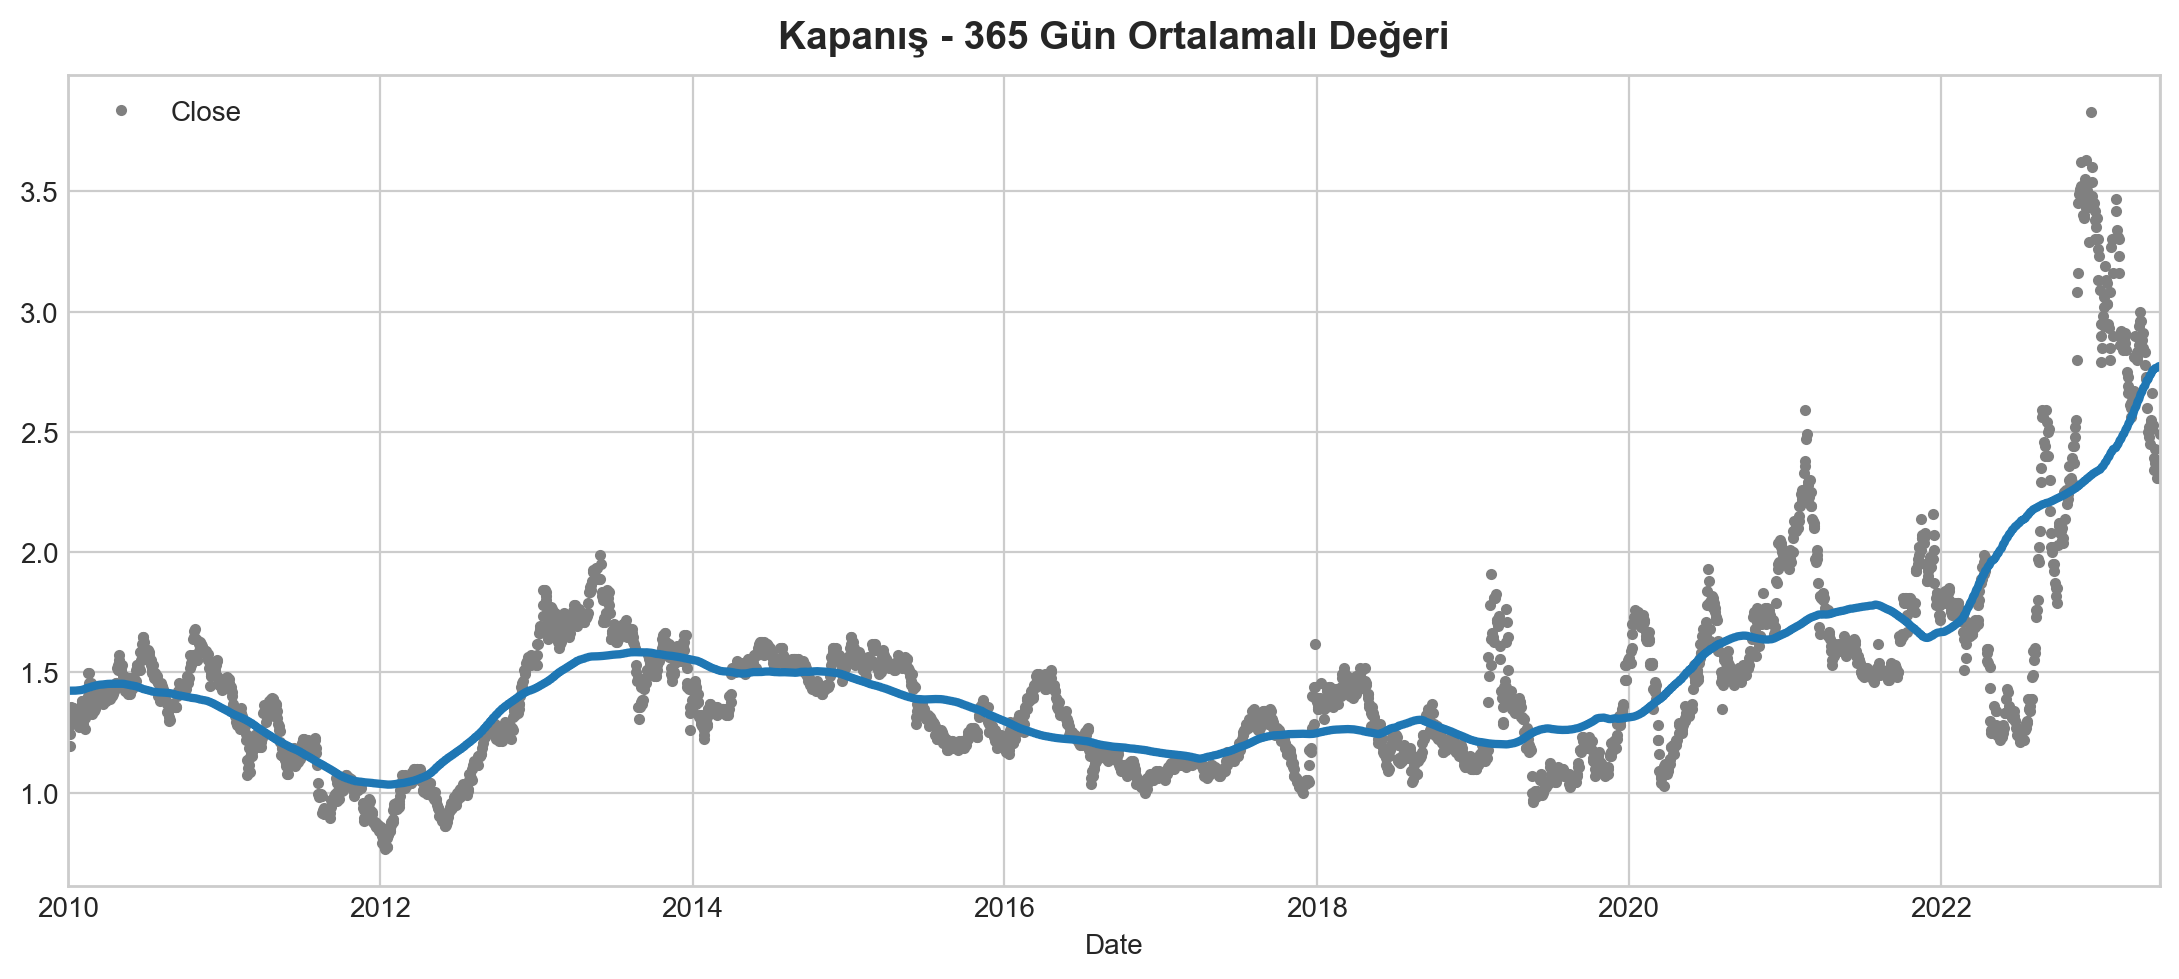

In [3]:
moving_average = stock.rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = stock.plot(style=".", color="0.5")
moving_average.plot(
    ax=ax, linewidth=3, title="Kapanış - 365 Gün Ortalamalı Değeri", legend=False,
);

In [4]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(
    index=stock.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument
X = dp.in_sample()

X.head()

,const,trend
Date,,
2010-01-01,1.0,1.0
2010-01-04,1.0,2.0
2010-01-05,1.0,3.0
2010-01-06,1.0,4.0
2010-01-07,1.0,5.0


In [5]:
from sklearn.linear_model import LinearRegression

y = stock["Close"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Date
2010-01-01    1.133361
2010-01-04    1.133547
2010-01-05    1.133733
2010-01-06    1.133918
2010-01-07    1.134104
                ...   
2023-05-23    1.774595
2023-05-24    1.774781
2023-05-25    1.774966
2023-05-26    1.775152
2023-05-29    1.775338
Freq: D, Length: 3459, dtype: float64

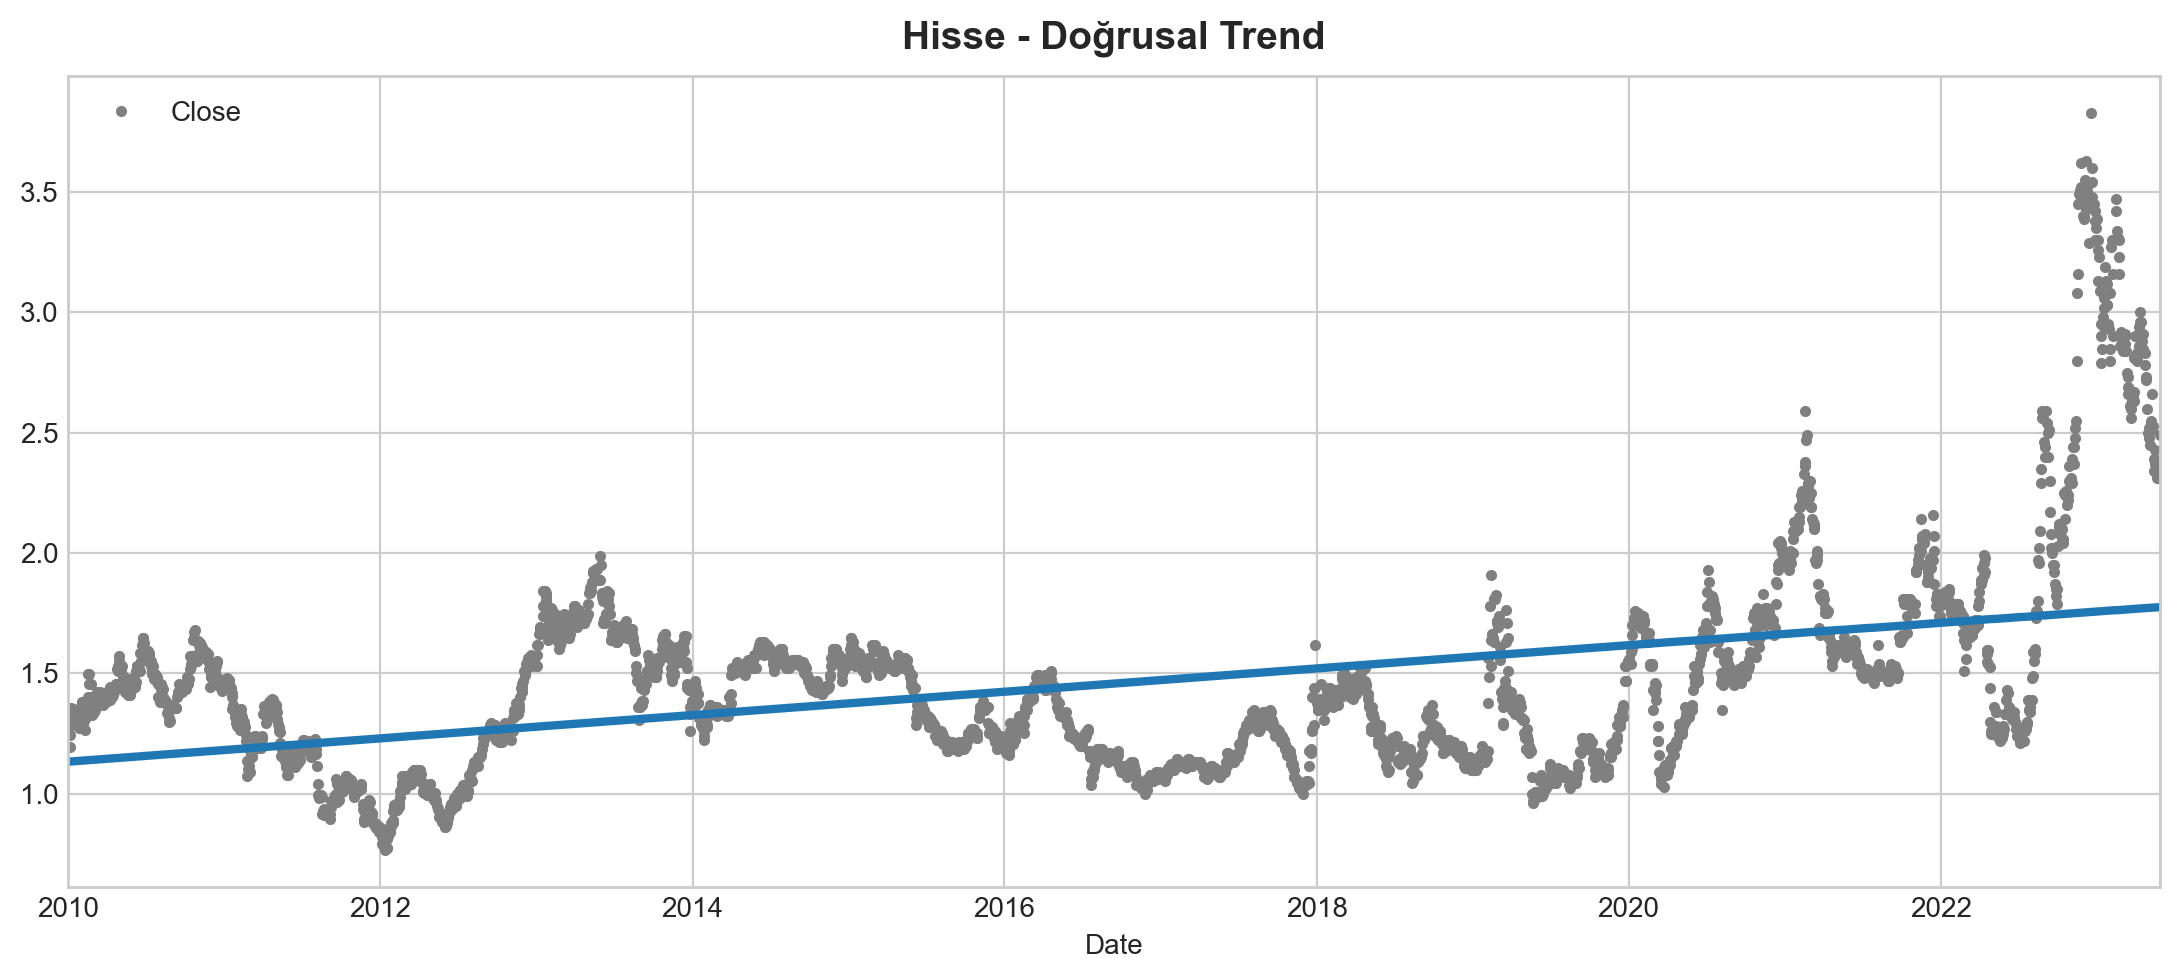

In [10]:
ax = stock.plot(style=".", color="0.5", title="Hisse - Doğrusal Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")

In [11]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2023-05-30    1.775523
2023-05-31    1.775709
2023-06-01    1.775895
2023-06-02    1.776080
2023-06-03    1.776266
Freq: D, dtype: float64

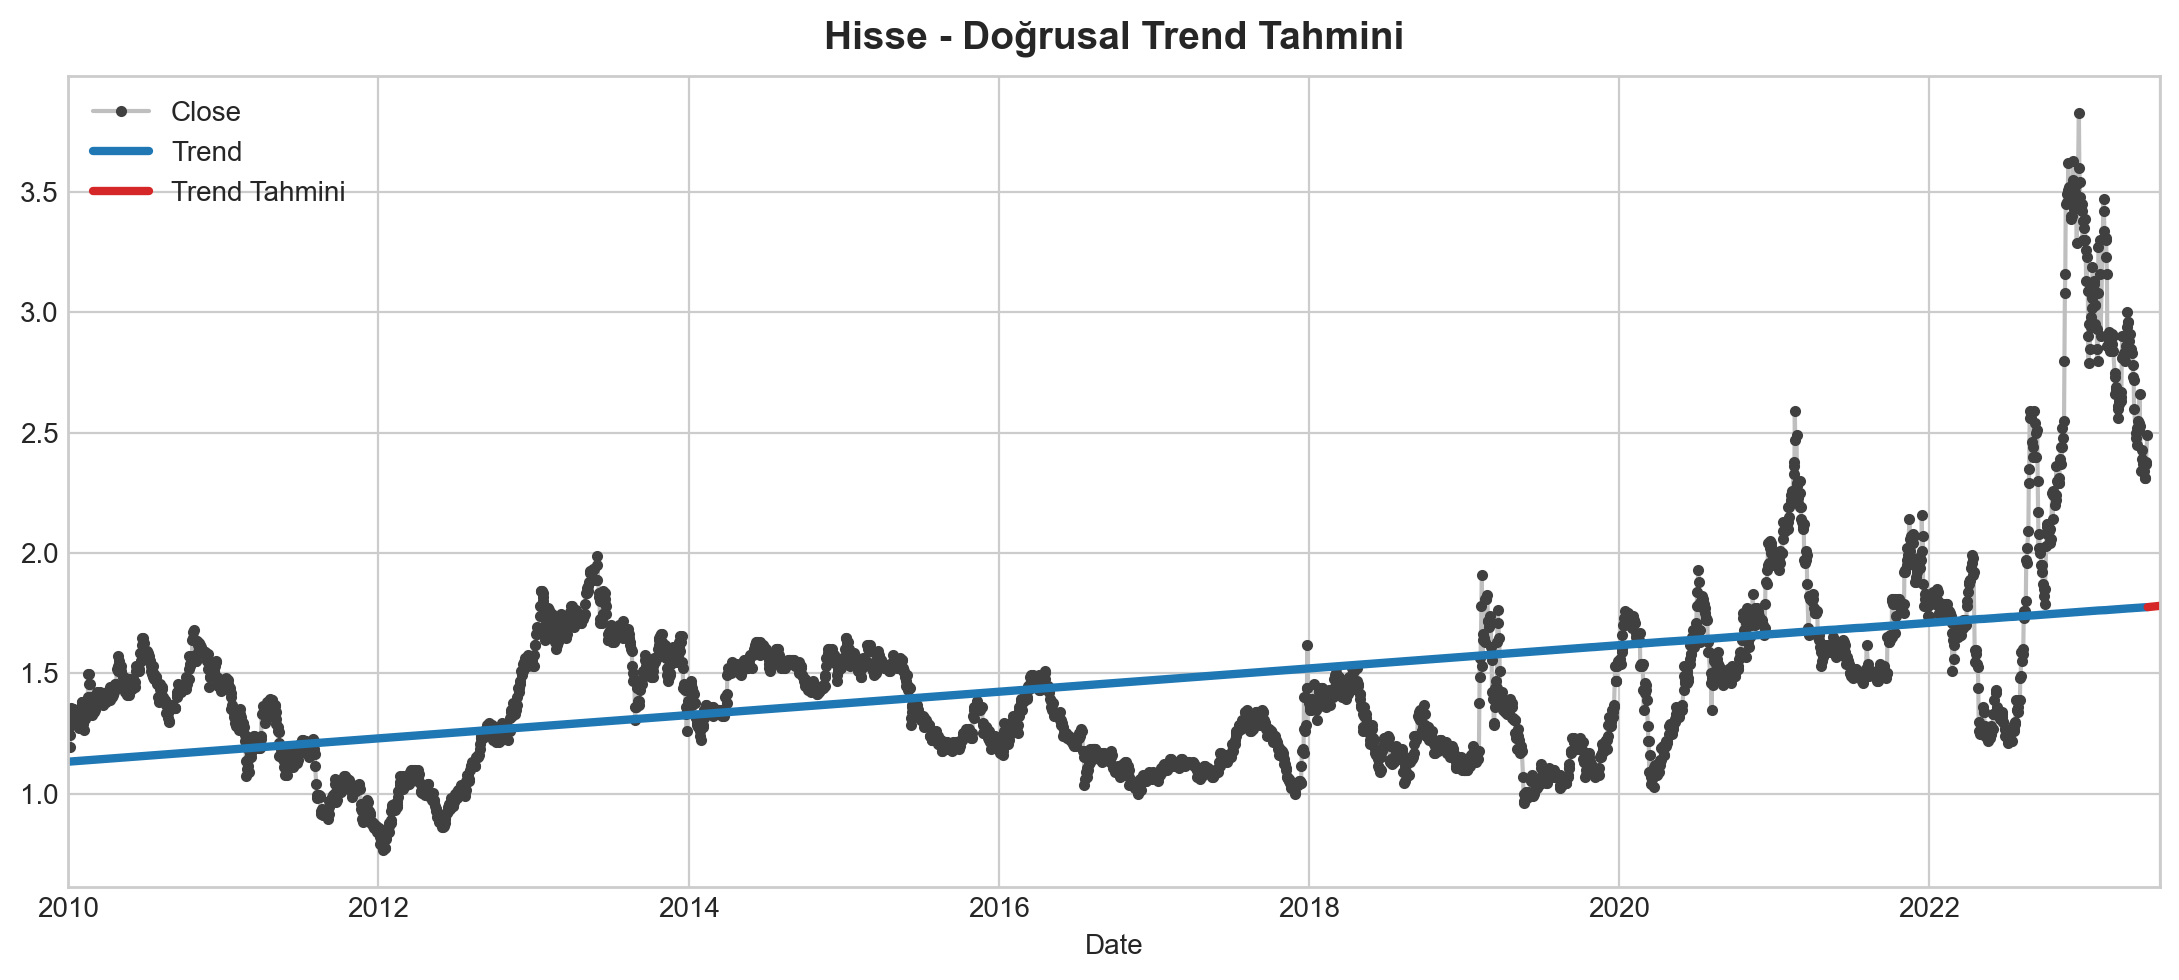

In [13]:
ax = stock["2010-01":].plot(title="Hisse - Doğrusal Trend Tahmini", **plot_params)
ax = y_pred["2010-01":].plot(ax=ax, linewidth=3, label="Trend")
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Tahmini", color="C3")
_ = ax.legend()